In [9]:
#ignore warning
import sys
import datetime

import numpy as np

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import pandas as pd
from matplotlib import pyplot as plt

### 录入数据

In [2]:
raw_data = pd.read_csv("test_data201803.csv")
raw_data['time'] = pd.to_datetime(raw_data['time'])

In [3]:
print(raw_data.head(5))

   Unnamed: 0                time    KWH
0           0 2006-01-02 00:59:00   0.00
1           1 2006-01-02 01:59:00   0.00
2           2 2006-01-02 02:59:00   0.00
3           3 2006-01-02 03:59:00  91.75
4           4 2006-01-02 04:59:00  68.50


### 无缺失值

In [4]:
raw_data.isna().sum()

Unnamed: 0    0
time          0
KWH           0
dtype: int64

### 无异常值

In [5]:
raw_data.KWH.unique()

array([   0.  ,   91.75,   68.5 , ..., 2815.  , 1867.5 , 2610.25])

### 特征工程

In [6]:
# 增加变量借鉴股价分析预测模型：
# https://github.com/a-bean-sprout/XGBoost_StockPricePredict/blob/master/XGBoost_StockPricePredict.py
features =pd.DataFrame(raw_data)
features['date'] = features['time'].dt.date
features['hour'] = features['time'].dt.hour

# 日高
a = features.groupby("date")["KWH"].max()
dict_a = {'date':a.index,'day_max':a.values}
df_a = pd.DataFrame(dict_a)
features = df_a.merge(features, left_on='date', right_on='date')

# 格式处理
features.rename(columns={'day_max_x': 'day_max'}, inplace=True)

# 日低
b = features.groupby("date")["KWH"].min()
dict_b = {'date':b.index,'day_min':b.values}
df_b = pd.DataFrame(dict_b)
features = df_b.merge(features, left_on='date', right_on='date')

# 每日用电差
features['日差'] = features['day_max'] - features['day_min']

features = features[['time', 'date', 'KWH', 'day_min', 'day_max', '日差']]
features.head(5)

,time,date,KWH,day_min,day_max,日差
0,2006-01-02 00:59:00,2006-01-02,0.00,0.0,3930.0,3930.0
1,2006-01-02 01:59:00,2006-01-02,0.00,0.0,3930.0,3930.0
2,2006-01-02 02:59:00,2006-01-02,0.00,0.0,3930.0,3930.0
3,2006-01-02 03:59:00,2006-01-02,91.75,0.0,3930.0,3930.0
4,2006-01-02 04:59:00,2006-01-02,68.50,0.0,3930.0,3930.0


In [7]:
# 根据节假日期，判断该用电数据可能来自家庭用电。增加变量借鉴股价分析预测模型：
# https://github.com/a-bean-sprout/XGBoost_StockPricePredict/blob/master/XGBoost_StockPricePredict.py
features['month'] = features['time'].dt.month

# 月高
a = features.groupby("month")["KWH"].max()
dict_a = {'month':a.index,'month_max':a.values}
df_a = pd.DataFrame(dict_a)
features = df_a.merge(features, left_on='month', right_on='month')

# 格式处理
features.rename(columns={'month_max_x': 'month_max'}, inplace=True)

# 月低
b = features.groupby("month")["KWH"].min()
dict_b = {'month':b.index,'month_min':b.values}
df_b = pd.DataFrame(dict_b)
features = df_b.merge(features, left_on='month', right_on='month')


In [10]:
# 每月用电差
features['月差'] = features['month_max'] - features['month_min']
features = features[['time', 'date', 'month', 'KWH', 'day_min', 'day_max', '日差', 'month_min', 'month_max', '月差']]

features['KWH_t_1'] = features['KWH'].shift(1)
#
features['KWH_t_1'] = features['KWH_t_1'].replace(np.nan, 0)
features.drop([0, len(features)-1])

features.head(5)

,time,date,month,KWH,day_min,day_max,日差,month_min,month_max,月差,KWH_t_1
0,2006-01-02 00:59:00,2006-01-02,1,0.00,0.0,3930.0,3930.0,0.0,4060.0,4060.0,0.00
1,2006-01-02 01:59:00,2006-01-02,1,0.00,0.0,3930.0,3930.0,0.0,4060.0,4060.0,0.00
2,2006-01-02 02:59:00,2006-01-02,1,0.00,0.0,3930.0,3930.0,0.0,4060.0,4060.0,0.00
3,2006-01-02 03:59:00,2006-01-02,1,91.75,0.0,3930.0,3930.0,0.0,4060.0,4060.0,0.00
4,2006-01-02 04:59:00,2006-01-02,1,68.50,0.0,3930.0,3930.0,0.0,4060.0,4060.0,91.75


### 总用电量分布

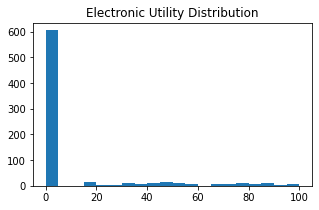

In [11]:
raw_data = raw_data.set_index('time')

fig, ax = plt.subplots(figsize =(5, 3))
ax.hist(raw_data['KWH'], bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.title('Electronic Utility Distribution')
plt.show()

In [12]:
# 用电量为0的占比7.08%
counts = raw_data.KWH.value_counts() 
counts = pd.DataFrame(counts, columns=['KWH', 'counts'])
print('最常见用电量（0度）出现次数:',counts['KWH'].max(),'次')

最常见用电量（0度）出现次数: 605 次


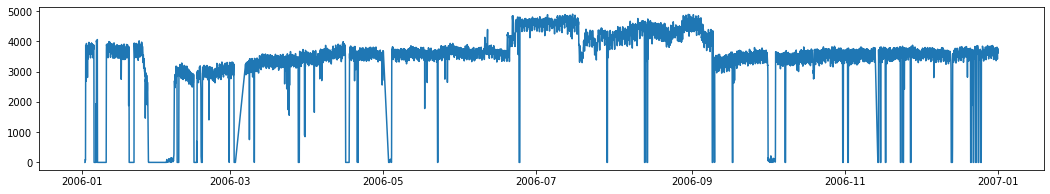

In [13]:
raw_data.head(5)
fig, ax = plt.subplots(figsize =(18, 3))
raw_data.reset_index(inplace=True)
plt.plot(raw_data.time, raw_data.KWH)

### 切分训练、测试数集

In [15]:
# 1-11月份数集为训练数集
features['date'] = pd.to_datetime(features['date'])
train = features.loc[(features['date'] >= '2006-01') & (features['date'] <= '2006-11')]

# 建模
X_train = train.drop(['KWH','time','date'], axis=1)
y_train = train['KWH']

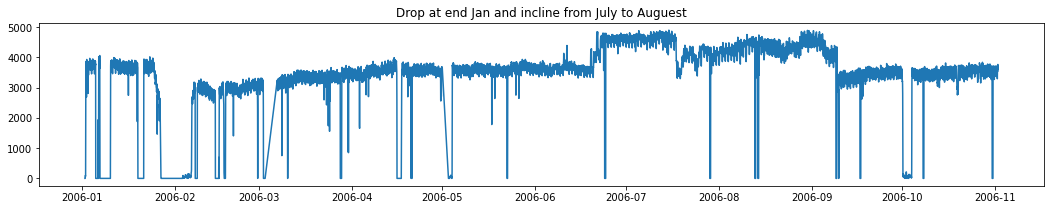

In [16]:
fig, ax = plt.subplots(figsize =(18, 3))
plt.title('Drop at end Jan and incline from July to Auguest')
plt.plot(train.time, train.KWH)
plt.show()

### 春节期间用电降低

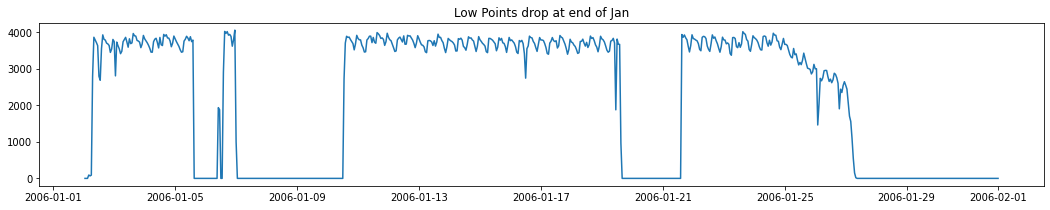

In [17]:
# 企业放假、个人出行
fig, ax = plt.subplots(figsize =(18, 3))
low = features.loc[(features['date'] >= '2006-01') & (features['date'] <= '2006-02')]
low.reset_index(inplace=True)
plt.title('Low Points drop at end of Jan')
plt.plot(low.time, low.KWH)
plt.show()

### 12月13日，21-25日用电呈间断性下降趋势

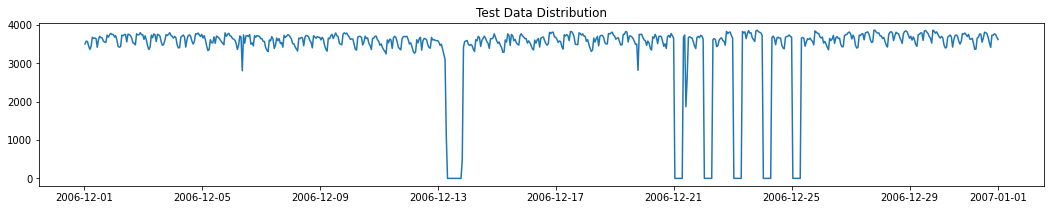

In [18]:
# 12月份数集为测试数集
fig, ax = plt.subplots(figsize =(18, 3))
test = features.loc[(features['date'] >= '2006-12') & (features['date'] < '2007-01')]
test.reset_index(inplace=True)
plt.title('Test Data Distribution')
plt.plot(test.time, test.KWH)
plt.show()

In [19]:
X_test = test.drop(['KWH','time','date'], axis=1)
y_test = test['KWH']

### 7月上旬用电量呈现趋势稳定，下旬用电量总体下降，29日用电量呈现单次骤减

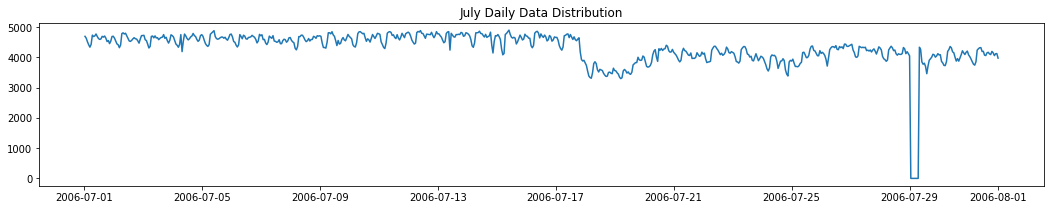

In [20]:
# 7月日用电分布
fig, ax = plt.subplots(figsize =(18, 3))
July = features.loc[(features['date'] >= '2006-07') & (features['date'] < '2006-08')]
July.reset_index(inplace=True)
plt.title('July Daily Data Distribution')
plt.plot(July.time, July.KWH)
plt.show()

### 8月用电量总体平稳，13-14日呈间断性下降趋势

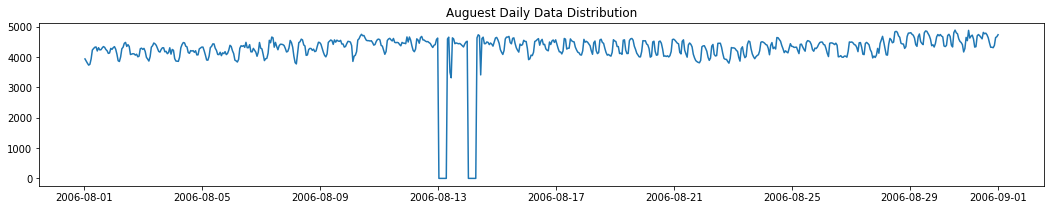

In [21]:
# 8月日用电分布
fig, ax = plt.subplots(figsize =(18, 3))
Auguest = features.loc[(features['date'] >= '2006-08') & (features['date'] < '2006-09')]
Auguest.reset_index(inplace=True)
plt.title('Auguest Daily Data Distribution')
plt.plot(Auguest.time, Auguest.KWH)
plt.show()

### XGBoost 建模

In [38]:
from sklearn import model_selection
import xgboost as xgb

model_seed = 100

parameters={'n_estimators':[90], # 1/10 sample size比较合理，但此处为节省运算时长，设置为90
                'max_depth':[5, 7],
                'learning_rate': [0.1, 0.2, 0.3],
                'min_child_weight':range(5, 21, 1)}

model=xgb.XGBRegressor(seed=model_seed,
                         n_estimators=100,
                         max_depth=3,
                         eval_metric='rmse',
                         learning_rate=0.1,
                         min_child_weight=1,
                         subsample=1,
                         colsample_bytree=1,
                         colsample_bylevel=1,
                         gamma=0)

gs=model_selection.GridSearchCV(estimator= model,param_grid=parameters,cv=5,refit= True,scoring='neg_mean_absolute_error')
gs.fit(X_train,y_train)

[04:57:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:57:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:57:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:57:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:57:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:57:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:57:14] WARNI

GridSearchCV(cv=5, estimator=XGBRegressor(eval_metric='rmse', seed=100),
             param_grid={'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [5, 7],
                         'min_child_weight': range(5, 21),
                         'n_estimators': [90]},
             scoring='neg_mean_absolute_error')

### 模型结构测评

In [ ]:
print ('最优参数: ' + str(gs.best_params_))
print ('MAPE: ', ((y_test.mean() - pd.Series(gs.predict(X_test.drop(['index'], axis=1)).tolist()).mean() ) / y_test.mean() * 100))

In [31]:
from sklearn import preprocessing
import numpy as np
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

In [32]:
# Model trained by scaled data
model_seed = 200

parameters={'n_estimators':[90],
                'max_depth':[7],
                'learning_rate': [0.3],
                'min_child_weight':range(5, 21, 1)
                }

model=xgb.XGBRegressor(seed=model_seed,
                         n_estimators=100,
                         max_depth=3,
                         eval_metric='rmse',
                         learning_rate=0.1,
                         min_child_weight=1,
                         subsample=1,
                         colsample_bytree=1,
                         colsample_bylevel=1,
                         gamma=0)
gs=model_selection.GridSearchCV(estimator= model,param_grid=parameters,cv=5,refit= True,scoring='neg_mean_absolute_error')
gs.fit(X_train_scaled, y_train_scaled)

[04:18:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:18:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:18:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:18:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:18:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:18:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:18:53] WARNI

GridSearchCV(cv=5, estimator=XGBRegressor(eval_metric='rmse', seed=200),
             param_grid={'learning_rate': [0.3], 'max_depth': [7],
                         'min_child_weight': range(5, 21),
                         'n_estimators': [90]},
             scoring='neg_mean_absolute_error')

In [39]:
print ('归一化数据最优参数: ' + str(gs.best_params_))
print ('MAPE: ', ((y_test.mean() - pd.Series(gs.predict(X_test.drop(['index'], axis=1)).tolist()).mean() ) / y_test.mean() * 100))

归一化数据最优参数: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 90}
MAPE:  0.3511767825559668
